# (1) SHIFT CV WINTER 2023 - Blurred Image Detection via Convolutional Neural Network (CNN)
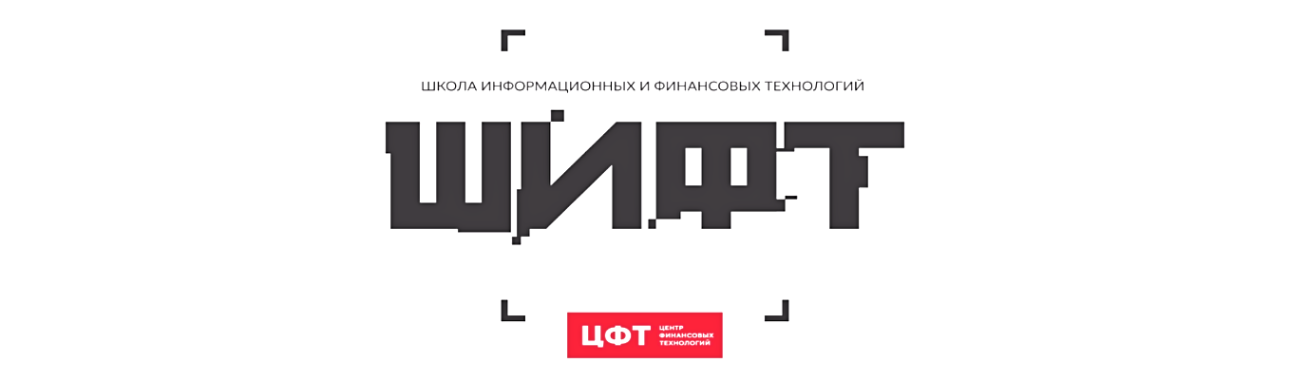

### Project Description
There is a dataset of images, par of which is blurred. The task is to develop a machine learning algorithm to detect whether the image is blurred or sharp on the unknown dataset.

### Data Description
The dataset consists of images, and some of them are blurred. The images are blurred using augmentation.

Data files:
- ```train``` - a folder for training
- ```test``` - a folder with images, for which we make predicitons
- ```train.csv``` - labels (answers) to the train sample: **if 1, the image is blurred.**


In [3]:
pip install -qqq ipyplot

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import ssl
# import torch
import glob

from ipyplot import plot_images
from pylab import *
from PIL import Image
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from keras import regularizers, optimizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

2023-01-16 03:08:54.389642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1 Загрузка и преобработка данных

### 1.1 Загрузка и предобработка целевого признака [0, 1], где 0 = фото НЕ заблюрено, 1 = фото заблюрено

In [2]:
train = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train.csv')
train.head()

,filename,blur
0,kagouracdzwrjjxzzedi.jpg,0.0
1,ahnamimqdfqoqdnozabc.jpg,0.0
2,gwhdadvghuzinmzhzssx.jpg,0.0
3,onqwabwwckubrydgbzly.jpg,0.0
4,ewpqdruddbokqyzzupcw.jpg,1.0


#### 1.1.1 Изучим формат данных таргетного значения.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  2664 non-null   object 
 1   blur      2664 non-null   float64
dtypes: float64(1), object(1)
memory usage: 41.8+ KB


In [4]:
train['blur'].unique()

array([0., 1.])

In [5]:
print(len(train))

2664


#### 1.1.2 Изучим описательные статистики таргетного значения и распределение.

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
blur,2664.0,0.486862,0.499921,0.0,0.0,0.0,1.0,1.0


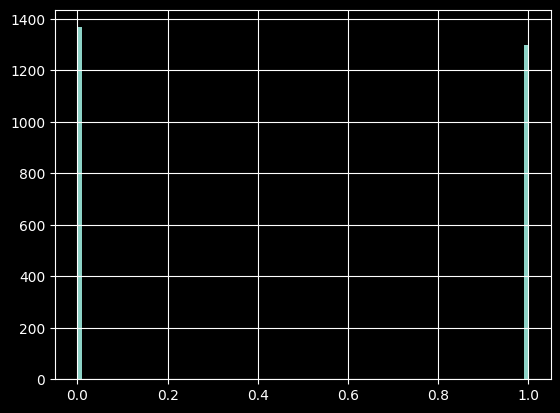

In [7]:
train['blur'].hist(bins=100);

#### 1.1.3 Проверим, есть ли в таргетном значении пропуски и дубликаты.

In [8]:
train.isna().sum()

filename    0
blur        0
dtype: int64

In [9]:
train.duplicated().sum()

0

#### 1.1.4 Проверим таргетное значение на наличие дисбаланса.

In [10]:
train_df = pd.DataFrame(train)

In [11]:
train_df['blur'].value_counts()

0.0    1367
1.0    1297
Name: blur, dtype: int64

In [12]:
train_blur = train[train["blur"]==1]
train_sharp = train[train["blur"]==0]

print("Blur images:", len(train_blur))
print("Sharp images:", len(train_sharp))

Blur images: 1297
Sharp images: 1367


### Вывод: тип переменных таргетного значения  float64 принимает только два уникальных значения 0 или 1, что подходит нам для решения задачи классификации. Количество наблюдений в обучающем датасете - 2664. Таргет сбалансирован.

## 1.2 Загрузка изображений

Для обучающей и валидационной выборок создадим разные генераторы изображений. Так как размер обучающей выборки небольшой, применим аугментацию.

In [13]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

#### Чтобы загрузчик извлёк данные из папки, вызовем функцию ```flow_from_directory()``` (англ. «поток из директории»):

In [14]:
train_datagen_flow = train_datagen.flow_from_directory(
    '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train',
    target_size=(150, 150),
    batch_size=30,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_flow = validation_datagen.flow_from_directory(
    '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train',
    target_size=(150, 150),
    batch_size=30,
    class_mode='sparse',
    subset='validation',
    seed=12345)

Found 1998 images belonging to 1 classes.
Found 666 images belonging to 1 classes.


Напечатаем значения пикселей изображения из первого батча обучающей выборки.

In [15]:
print(next(train_datagen_flow)[0][0])

[[[0.05450368 0.06234682 0.05058211]
  [0.05099449 0.05883763 0.04707292]
  [0.0470508  0.05489394 0.04312923]
  ...
  [0.3578338  0.36567694 0.2794024 ]
  [0.33699068 0.3384982  0.25433558]
  [0.3032744  0.29935282 0.2054451 ]]

 [[0.05685279 0.06469593 0.05293122]
  [0.0559564  0.06379955 0.05203484]
  [0.05814032 0.06598346 0.05421875]
  ...
  [0.3581425  0.36598563 0.27971113]
  [0.31671524 0.31958488 0.23496819]
  [0.2584827  0.25456113 0.15975362]]

 [[0.05695378 0.06479692 0.05303221]
  [0.0597959  0.06763904 0.05587433]
  [0.06219716 0.07004031 0.0582756 ]
  ...
  [0.3400042  0.34784734 0.2615728 ]
  [0.29078397 0.29501572 0.20994502]
  [0.18188792 0.17796636 0.08769917]]

 ...

 [[0.45997468 0.5249     0.45198765]
  [0.44094485 0.5087247  0.43533656]
  [0.42191505 0.49254936 0.4186855 ]
  ...
  [0.6681921  0.7005644  0.60744643]
  [0.6085358  0.62188834 0.54435205]
  [0.5326494  0.546309   0.45894694]]

 [[0.38550127 0.46001107 0.38550127]
  [0.3826468  0.4571566  0.3826468 ]


In [853]:
features, target = next(train_datagen_flow)

Выведем на экран 30 изображений.

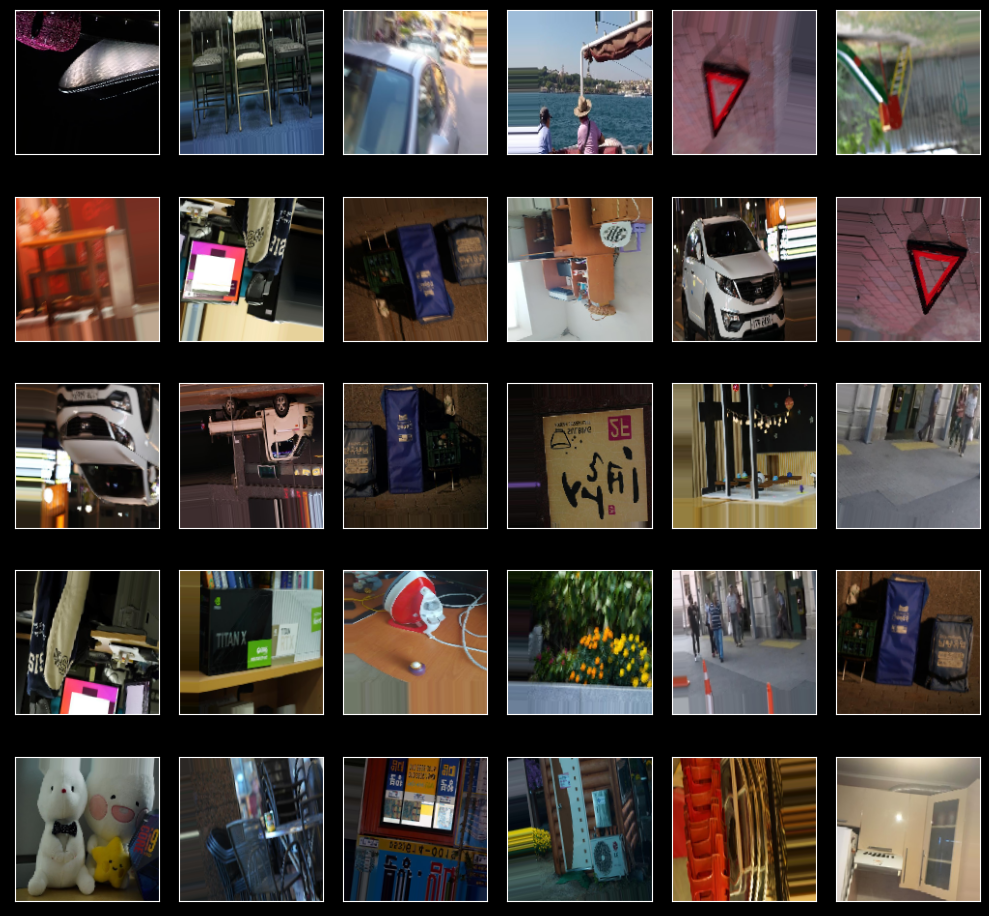

In [854]:
fig = plt.figure(figsize=(10,10))
for i in range(30):
    fig.add_subplot(5, 6, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [855]:
print(features[0][0])

[[3.45528871e-01 3.24041247e-01 4.14728135e-01]
 [4.62998450e-01 4.37920064e-01 5.31684756e-01]
 [5.80467999e-01 5.51798880e-01 6.48641348e-01]
 [6.97937608e-01 6.65677726e-01 7.65597939e-01]
 [8.15407157e-01 7.79556513e-01 8.82554591e-01]
 [4.01564509e-01 3.46198261e-01 4.32007253e-01]
 [1.81403831e-01 7.42559433e-02 1.31134883e-01]
 [1.71424076e-01 4.82707918e-02 9.87530723e-02]
 [2.40774468e-01 1.24956898e-01 1.89393133e-01]
 [2.53756523e-01 1.42358616e-01 2.23104849e-01]
 [2.95212835e-01 2.16607839e-01 2.72819400e-01]
 [7.99677074e-01 7.48428464e-01 7.70695686e-01]
 [3.30172271e-01 2.11344630e-01 2.80197054e-01]
 [3.49550039e-01 1.81619480e-01 2.68807679e-01]
 [3.35930079e-01 1.91256687e-01 2.86581278e-01]
 [1.92845032e-01 1.11599721e-01 1.74391836e-01]
 [1.65778041e-01 9.40076038e-02 1.23199776e-01]
 [2.16850474e-01 1.15912363e-01 1.41248137e-01]
 [1.08242519e-01 2.42112447e-02 4.66818586e-02]
 [1.15167387e-01 2.38377769e-02 5.53138778e-02]
 [6.40431643e-02 1.28761318e-03 1.412632

In [2]:
img = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train/train/aaashhimmhraddpwwizz.jpg')
img

NameError: name 'Image' is not defined

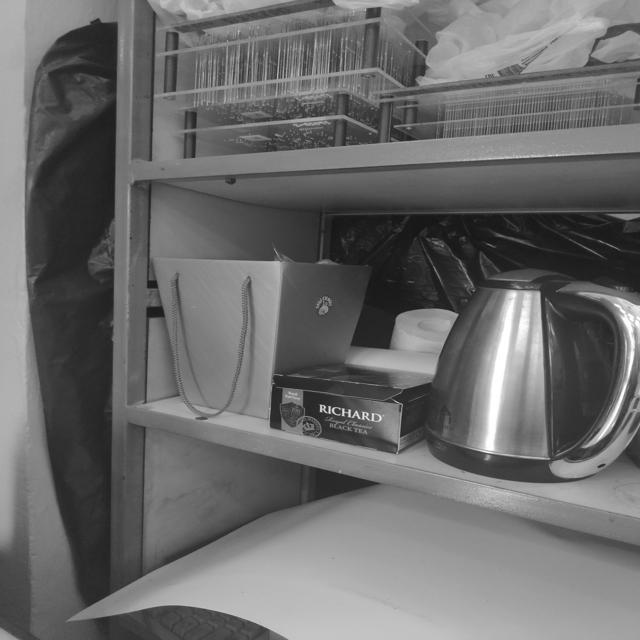

In [857]:
img2 = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train/train/aaashhimmhraddpwwizz.jpg').convert('L')
img2

In [858]:
# прочитаем изображение
im = array(Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train/train/aaashhimmhraddpwwizz.jpg'))

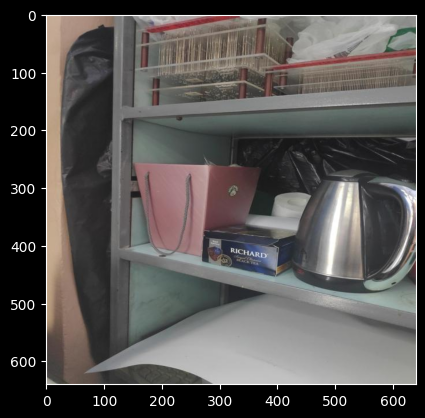

In [859]:
# поместим на график изображение
imshow(im);

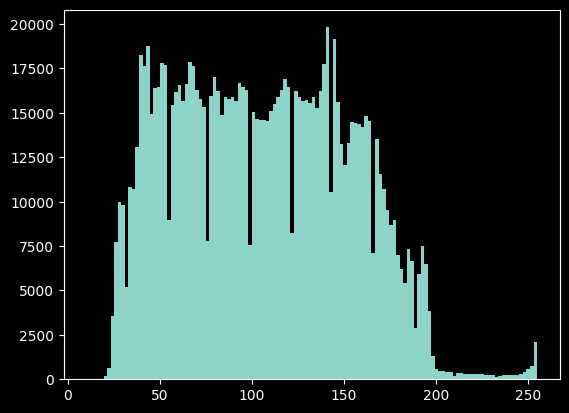

In [860]:
# диаграмма распределения пикселей
figure()
hist(im.flatten(), 128);

#### Выведем кортеж, который описывает форму массива изображения (количество строк, столбцов и цветовых каналов), а также - тип дпнных, хранящихся в элементах массива.

Изображения обычно кодируются 8-разрядными целыми без знака (unit8), поэтому после загрузки и преобразования изображения печатается тип unit8.

In [861]:
print(im.shape, im.dtype)

(640, 640, 3) uint8


#### Преобразуем изображение и полутоновое изображение, указав дополнительный аргумент ```'f' ```. Информация о цвете не требуется, поэтому количество каналов не указывается.

In [862]:
# прочитаем изображение
im_float = array(Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train/train/aaashhimmhraddpwwizz.jpg').convert('L'), 'f')
print(im_float.shape, im_float.dtype)

(640, 640) float32


In [863]:
# инвертировать изображение
im2 = 255 - im
im2

array([[[ 60,  85, 107],
        [ 60,  85, 107],
        [ 60,  85, 107],
        ...,
        [110, 110, 112],
        [109, 109, 111],
        [108, 108, 110]],

       [[ 60,  85, 107],
        [ 60,  85, 107],
        [ 60,  85, 107],
        ...,
        [110, 110, 112],
        [109, 109, 111],
        [108, 108, 110]],

       [[ 60,  85, 107],
        [ 60,  85, 107],
        [ 60,  85, 107],
        ...,
        [110, 110, 112],
        [109, 109, 111],
        [108, 108, 110]],

       ...,

       [[ 89,  94,  98],
        [ 90,  95,  99],
        [ 92,  95, 100],
        ...,
        [ 95,  94, 100],
        [ 95,  94, 100],
        [ 95,  94, 100]],

       [[ 87,  92,  95],
        [ 89,  94,  97],
        [ 91,  95,  98],
        ...,
        [ 95,  94, 100],
        [ 95,  94, 100],
        [ 95,  94, 100]],

       [[ 85,  90,  93],
        [ 87,  92,  95],
        [ 89,  93,  96],
        ...,
        [ 95,  94, 100],
        [ 95,  94, 100],
        [ 95,  94, 100]]

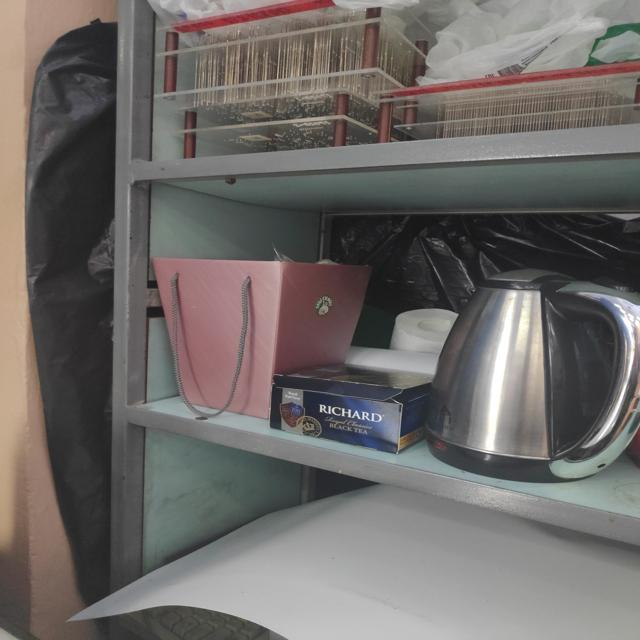

In [864]:
pil_im = Image.fromarray(im)
pil_im

In [865]:
# привести к интервалу 100 ... 200
im3 = (100.0/255) * im + 100
im3

array([[[176.47058824, 166.66666667, 158.03921569],
        [176.47058824, 166.66666667, 158.03921569],
        [176.47058824, 166.66666667, 158.03921569],
        ...,
        [156.8627451 , 156.8627451 , 156.07843137],
        [157.25490196, 157.25490196, 156.47058824],
        [157.64705882, 157.64705882, 156.8627451 ]],

       [[176.47058824, 166.66666667, 158.03921569],
        [176.47058824, 166.66666667, 158.03921569],
        [176.47058824, 166.66666667, 158.03921569],
        ...,
        [156.8627451 , 156.8627451 , 156.07843137],
        [157.25490196, 157.25490196, 156.47058824],
        [157.64705882, 157.64705882, 156.8627451 ]],

       [[176.47058824, 166.66666667, 158.03921569],
        [176.47058824, 166.66666667, 158.03921569],
        [176.47058824, 166.66666667, 158.03921569],
        ...,
        [156.8627451 , 156.8627451 , 156.07843137],
        [157.25490196, 157.25490196, 156.47058824],
        [157.64705882, 157.64705882, 156.8627451 ]],

       ...,

      

In [866]:
im4 = 255.0 * (im/255.0) ** 2
im4

array([[[149.11764706, 113.33333333,  85.89803922],
        [149.11764706, 113.33333333,  85.89803922],
        [149.11764706, 113.33333333,  85.89803922],
        ...,
        [ 82.45098039,  82.45098039,  80.19215686],
        [ 83.59215686,  83.59215686,  81.31764706],
        [ 84.74117647,  84.74117647,  82.45098039]],

       [[149.11764706, 113.33333333,  85.89803922],
        [149.11764706, 113.33333333,  85.89803922],
        [149.11764706, 113.33333333,  85.89803922],
        ...,
        [ 82.45098039,  82.45098039,  80.19215686],
        [ 83.59215686,  83.59215686,  81.31764706],
        [ 84.74117647,  84.74117647,  82.45098039]],

       [[149.11764706, 113.33333333,  85.89803922],
        [149.11764706, 113.33333333,  85.89803922],
        [149.11764706, 113.33333333,  85.89803922],
        ...,
        [ 82.45098039,  82.45098039,  80.19215686],
        [ 83.59215686,  83.59215686,  81.31764706],
        [ 84.74117647,  84.74117647,  82.45098039]],

       ...,

      

In [867]:
test_imgs = []
for file in glob.glob('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/*.jpg'):
    test_imgs.append({'filename' : file})
    
test = pd.DataFrame(test_imgs)
print('Test images: ', len(test))

Test images:  774


In [869]:
# images = train_sharp.filename.sample(6).tolist()
# plot_images(images, max_images=10,img_width=220,force_b64=True)

## 1.3 Фукнции для создания выборок для обучения и тестирования

In [880]:
path = '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/'

In [881]:
def load_train(path):
    labels = pd.read_csv(path + 'train.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True, 
                                       rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'train/train/',
        x_col='filename',
        y_col='blur',
        target_size=(224, 224),
        batch_size=30,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    val_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'train/train/',
        x_col='filename',
        y_col='blur',
        target_size=(224, 224),
        batch_size=30,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return train_gen_flow, val_gen_flow

In [882]:
train_gen_flow, val_gen_flow = load_train(path)

Found 1998 validated image filenames.
Found 666 validated image filenames.


In [883]:
# def load_test(path):
#     labels = pd.read_csv(path + 'train.csv')
#     test_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
#     test_gen_flow = test_datagen.flow_from_dataframe(
#         dataframe=labels,
#         directory=path + 'test/test/',
#         x_col='filename',
#         y_col='blur',
#         target_size=(224, 224),
#         batch_size=30,
#         class_mode='raw',
#         subset='validation',
#         seed=12345)

#     return test_gen_flow

In [884]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [885]:
def basic_model(input_shape):
    model = Sequential()
    
#     model.add(layers.Reshape(, input_shape=input_shape))
    
    model.add(Conv2D(4, (3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer,loss='mean_squared_error',
                  metrics=['mae'])
    
    return model

In [886]:
ssl._create_default_https_context = ssl._create_unverified_context

In [887]:
resnet_model = create_model([64, 64, 3])

In [888]:
def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=30,
                steps_per_epoch=None, 
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## 2 Constructing the CNN

In [19]:
train = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/train.csv',
                   delimiter=',')
train.head()

,filename,blur
0,kagouracdzwrjjxzzedi.jpg,0.0
1,ahnamimqdfqoqdnozabc.jpg,0.0
2,gwhdadvghuzinmzhzssx.jpg,0.0
3,onqwabwwckubrydgbzly.jpg,0.0
4,ewpqdruddbokqyzzupcw.jpg,1.0


In [20]:
train['blur']=train['blur'].astype(str)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2664 entries, 0 to 2663
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2664 non-null   object
 1   blur      2664 non-null   object
dtypes: object(2)
memory usage: 41.8+ KB


In [22]:
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25)

In [23]:
path = '/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/'

In [29]:
train_generator=datagen.flow_from_dataframe(dataframe=train,
                                            directory=path+'/train/train', 
                                            x_col="filename", 
                                            y_col="blur", 
                                            class_mode="binary", 
                                            target_size=(32,32),
                                            color_mode='rgb',
                                            batch_size=32,
                                           shuffle=False,
                                           subset='training')

Found 1998 validated image filenames belonging to 2 classes.


In [30]:
# англ. индексы классов
print(train_generator.class_indices)

{'0.0': 0, '1.0': 1}


In [37]:
features_train, target_train = next(train_generator)
print(features_train.shape)
print(target_train.shape)

(32, 32, 32, 3)
(32,)


In [38]:
print(next(train_generator)[0][0])

[[[0.18431373 0.20000002 0.24313727]
  [0.21960786 0.2392157  0.2509804 ]
  [0.23137257 0.25490198 0.25490198]
  ...
  [0.09411766 0.09019608 0.08235294]
  [0.13333334 0.12941177 0.1137255 ]
  [0.10980393 0.1254902  0.12941177]]

 [[0.09411766 0.1137255  0.12941177]
  [0.22352943 0.24705884 0.24705884]
  [0.05882353 0.07058824 0.20784315]
  ...
  [0.10196079 0.08627451 0.08235294]
  [0.41176474 0.7058824  0.8313726 ]
  [0.41176474 0.70980394 0.85098046]]

 [[0.20392159 0.22352943 0.23529413]
  [0.20000002 0.2509804  0.28235295]
  [0.03137255 0.08235294 0.15686275]
  ...
  [0.4431373  0.7294118  0.89019614]
  [0.38431376 0.6862745  0.8588236 ]
  [0.5254902  0.7490196  0.86666673]]

 ...

 [[0.49411768 0.49411768 0.46274513]
  [0.6627451  0.654902   0.6039216 ]
  [0.75294125 0.7058824  0.6509804 ]
  ...
  [0.5921569  0.57254905 0.54901963]
  [0.48235297 0.47058827 0.4431373 ]
  [0.14509805 0.14117648 0.12156864]]

 [[0.7176471  0.68235296 0.6156863 ]
  [0.7058824  0.68235296 0.627451  ]


In [31]:
valid_generator=datagen.flow_from_dataframe(dataframe=train,
                                            directory=path+'/train/train', 
                                            x_col="filename", 
                                            y_col="blur", 
                                            class_mode="binary", 
                                            target_size=(32,32),
                                            color_mode='rgb',
                                            batch_size=32,
                                           shuffle=False,
                                           subset='validation')

Found 666 validated image filenames belonging to 2 classes.


In [32]:
# англ. индексы классов
print(valid_generator.class_indices)

{'0.0': 0, '1.0': 1}


In [36]:
features_valid, target_valid = next(valid_generator)
print(features_valid.shape)
print(target_valid.shape)

(32, 32, 32, 3)
(32,)


### Model 1:

- loss: 0.5660 
- accuracy: 0.7019 

- val_loss: 0.6229 
- val_accuracy: 0.6844 

In [979]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(2, activation='softmax'))

model1.compile(optimizer='Adamax', 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [980]:
model1.summary()

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_297 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 activation_345 (Activation)  (None, 32, 32, 32)       0         
                                                                 
 conv2d_298 (Conv2D)         (None, 30, 30, 32)        9248      
                                                                 
 activation_346 (Activation)  (None, 30, 30, 32)       0         
                                                                 
 max_pooling2d_148 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_185 (Dropout)       (None, 15, 15, 32)        0         
                                                    

In [981]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [982]:
model1 = model1.fit_generator(train_generator,
          validation_data=valid_generator,
          epochs=10,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/10
62/62 - 52s - loss: 0.6942 - accuracy: 0.5132 - val_loss: 0.6903 - val_accuracy: 0.5141 - 52s/epoch - 835ms/step
Epoch 2/10
62/62 - 29s - loss: 0.6880 - accuracy: 0.5351 - val_loss: 0.6830 - val_accuracy: 0.5594 - 29s/epoch - 475ms/step
Epoch 3/10
62/62 - 32s - loss: 0.6773 - accuracy: 0.5839 - val_loss: 0.6822 - val_accuracy: 0.5609 - 32s/epoch - 523ms/step
Epoch 4/10
62/62 - 27s - loss: 0.6690 - accuracy: 0.6038 - val_loss: 0.6682 - val_accuracy: 0.6016 - 27s/epoch - 429ms/step
Epoch 5/10
62/62 - 27s - loss: 0.6672 - accuracy: 0.6033 - val_loss: 0.6666 - val_accuracy: 0.6328 - 27s/epoch - 433ms/step
Epoch 6/10
62/62 - 28s - loss: 0.6536 - accuracy: 0.6221 - val_loss: 0.6604 - val_accuracy: 0.6187 - 28s/epoch - 459ms/step
Epoch 7/10
62/62 - 26s - loss: 0.6542 - accuracy: 0.6378 - val_loss: 0.6562 - val_accuracy: 0.6328 - 26s/epoch - 417ms/step
Epoch 8/10
62/62 - 34s - loss: 0.6477 - accuracy: 0.6317 - val_loss: 0.6618 - val_accuracy: 0.6422 - 34s/epoch - 542ms/step
Epoch 9/

### Model 2

In [937]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))

model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(2, activation='softmax'))
model2.compile(optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [938]:
model2.summary()

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_285 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 activation_331 (Activation)  (None, 32, 32, 32)       0         
                                                                 
 conv2d_286 (Conv2D)         (None, 30, 30, 32)        9248      
                                                                 
 activation_332 (Activation)  (None, 30, 30, 32)       0         
                                                                 
 max_pooling2d_142 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_179 (Dropout)       (None, 15, 15, 32)        0         
                                                    

In [939]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [940]:
model2 = model2.fit_generator(train_generator,
          validation_data=valid_generator,
          epochs=10,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/10
62/62 - 34s - loss: 0.6935 - accuracy: 0.5056 - val_loss: 0.6927 - val_accuracy: 0.5047 - 34s/epoch - 545ms/step
Epoch 2/10
62/62 - 23s - loss: 0.6904 - accuracy: 0.5504 - val_loss: 0.6930 - val_accuracy: 0.5031 - 23s/epoch - 364ms/step
Epoch 3/10
62/62 - 23s - loss: 0.6912 - accuracy: 0.5178 - val_loss: 0.6924 - val_accuracy: 0.5031 - 23s/epoch - 375ms/step
Epoch 4/10
62/62 - 24s - loss: 0.6868 - accuracy: 0.5514 - val_loss: 0.6862 - val_accuracy: 0.5641 - 24s/epoch - 381ms/step
Epoch 5/10
62/62 - 23s - loss: 0.6815 - accuracy: 0.5743 - val_loss: 0.6807 - val_accuracy: 0.5828 - 23s/epoch - 366ms/step
Epoch 6/10
62/62 - 24s - loss: 0.6784 - accuracy: 0.5677 - val_loss: 0.6978 - val_accuracy: 0.5266 - 24s/epoch - 382ms/step
Epoch 7/10
62/62 - 24s - loss: 0.6750 - accuracy: 0.5885 - val_loss: 0.6744 - val_accuracy: 0.5969 - 24s/epoch - 390ms/step
Epoch 8/10
62/62 - 23s - loss: 0.6660 - accuracy: 0.6022 - val_loss: 0.6772 - val_accuracy: 0.5969 - 23s/epoch - 368ms/step
Epoch 9/

### Model 3

In [957]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(10))
model3.add(Activation('relu'))
# model3.add(Dropout(0.5))
model3.add(Dense(2, activation='softmax'))

model3.compile(optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [958]:
model3.summary()

Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_293 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 activation_340 (Activation)  (None, 32, 32, 32)       0         
                                                                 
 conv2d_294 (Conv2D)         (None, 30, 30, 32)        9248      
                                                                 
 activation_341 (Activation)  (None, 30, 30, 32)       0         
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_183 (Dropout)       (None, 15, 15, 32)        0         
                                                    

In [959]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [960]:
model3 = model3.fit_generator(train_generator,
          validation_data=valid_generator,
          epochs=10,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/10
62/62 - 27s - loss: 0.6941 - accuracy: 0.5015 - val_loss: 0.6927 - val_accuracy: 0.5078 - 27s/epoch - 443ms/step
Epoch 2/10
62/62 - 23s - loss: 0.6923 - accuracy: 0.5158 - val_loss: 0.6912 - val_accuracy: 0.5578 - 23s/epoch - 373ms/step
Epoch 3/10
62/62 - 23s - loss: 0.6906 - accuracy: 0.5300 - val_loss: 0.6891 - val_accuracy: 0.5641 - 23s/epoch - 369ms/step
Epoch 4/10
62/62 - 23s - loss: 0.6875 - accuracy: 0.5509 - val_loss: 0.6869 - val_accuracy: 0.5625 - 23s/epoch - 366ms/step
Epoch 5/10
62/62 - 22s - loss: 0.6828 - accuracy: 0.5661 - val_loss: 0.6839 - val_accuracy: 0.5672 - 22s/epoch - 361ms/step
Epoch 6/10
62/62 - 27s - loss: 0.6786 - accuracy: 0.5727 - val_loss: 0.6804 - val_accuracy: 0.5766 - 27s/epoch - 438ms/step
Epoch 7/10
62/62 - 29s - loss: 0.6788 - accuracy: 0.5677 - val_loss: 0.6809 - val_accuracy: 0.5703 - 29s/epoch - 465ms/step
Epoch 8/10
62/62 - 23s - loss: 0.6728 - accuracy: 0.5860 - val_loss: 0.6762 - val_accuracy: 0.6031 - 23s/epoch - 378ms/step
Epoch 9/

## 3 Choosing the best CNN model

### 3.1 Model 1:

- loss: 0.5660 
- accuracy: 0.7019 

- val_loss: 0.6229 
- val_accuracy: 0.6844 

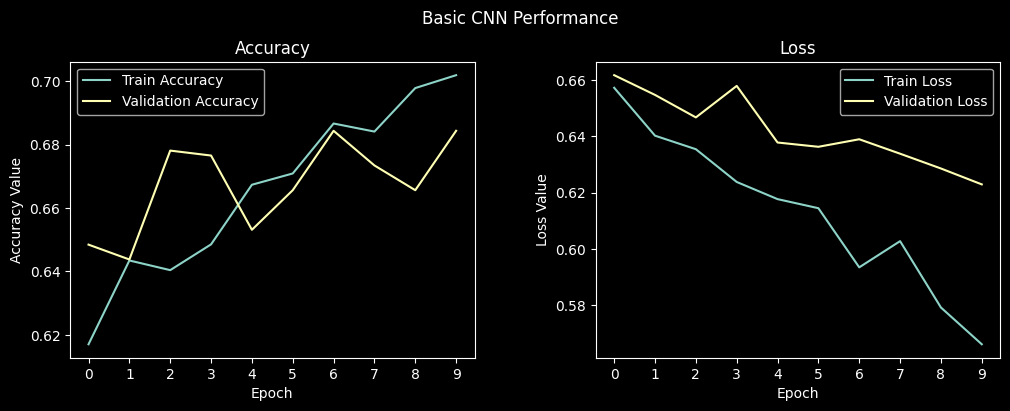

In [961]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,10))
ax1.plot(epoch_list, model1.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, model1.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, model1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, model1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### 3.2 Model 2:

- loss: 0.6690 
- accuracy: 0.5982 


- val_loss: 0.6701 
- val_accuracy: 0.6172

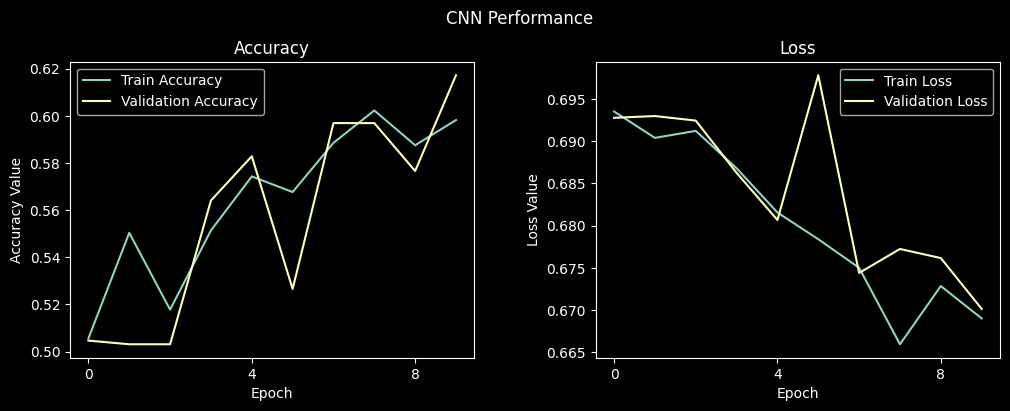

In [962]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,10))
ax1.plot(epoch_list, model2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, model2.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 10, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, model2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, model2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### 3.3 Model 3:

- loss: 0.6639 
- accuracy: 0.6012 

- val_loss: 0.6784 
- val_accuracy: 0.5891

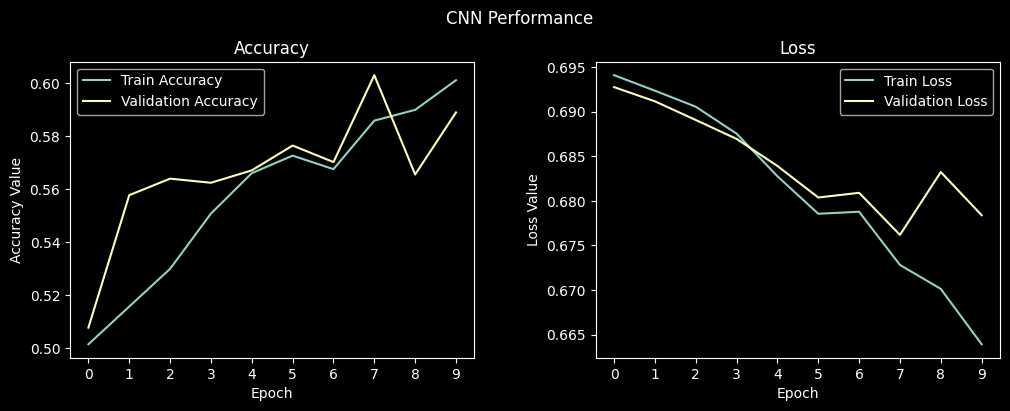

In [963]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,10))
ax1.plot(epoch_list, model3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, model3.history['val_accuracy'], label='Validation Accuracy')

ax1.set_xticks(np.arange(0, 10, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, model3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, model3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 10, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### ***Conclusion:*** The best model is Model 1.
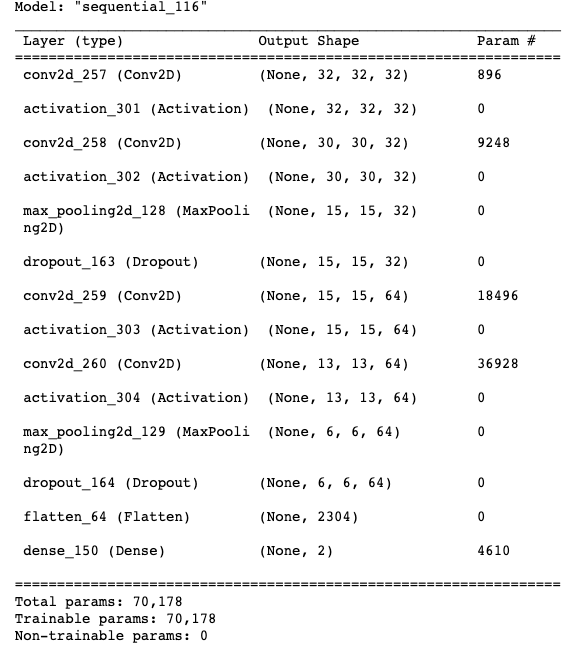

## 4 Testing the best model 1

### 4.1 Making predictions

In [1033]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_directory(
directory=path+'/test/',
batch_size=32,
seed=12345,
shuffle=False,
class_mode=None,
target_size=(32,32))

Found 774 images belonging to 1 classes.


In [996]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='Adamax', 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [997]:
history = model.fit_generator(train_generator,
          validation_data=valid_generator,
          epochs=20,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          verbose=2)

Epoch 1/20
62/62 - 30s - loss: 0.6946 - accuracy: 0.5056 - val_loss: 0.6911 - val_accuracy: 0.5172 - 30s/epoch - 488ms/step
Epoch 2/20
62/62 - 27s - loss: 0.6894 - accuracy: 0.5168 - val_loss: 0.6886 - val_accuracy: 0.5109 - 27s/epoch - 429ms/step
Epoch 3/20
62/62 - 26s - loss: 0.6863 - accuracy: 0.5422 - val_loss: 0.6848 - val_accuracy: 0.5406 - 26s/epoch - 421ms/step
Epoch 4/20
62/62 - 25s - loss: 0.6808 - accuracy: 0.5758 - val_loss: 0.6814 - val_accuracy: 0.5766 - 25s/epoch - 401ms/step
Epoch 5/20
62/62 - 23s - loss: 0.6714 - accuracy: 0.5966 - val_loss: 0.6762 - val_accuracy: 0.5688 - 23s/epoch - 369ms/step
Epoch 6/20
62/62 - 23s - loss: 0.6635 - accuracy: 0.6104 - val_loss: 0.6868 - val_accuracy: 0.5875 - 23s/epoch - 376ms/step
Epoch 7/20
62/62 - 23s - loss: 0.6574 - accuracy: 0.6043 - val_loss: 0.6660 - val_accuracy: 0.6016 - 23s/epoch - 370ms/step
Epoch 8/20
62/62 - 23s - loss: 0.6413 - accuracy: 0.6409 - val_loss: 0.6569 - val_accuracy: 0.6391 - 23s/epoch - 378ms/step
Epoch 9/

In [986]:
from keras.callbacks import History

In [1034]:
test_predict = model.predict_generator(test_generator)

In [1035]:
pred = test_predict
pred 

array([[0.9985043 , 0.00149569],
       [0.89091414, 0.10908582],
       [0.4631193 , 0.53688073],
       ...,
       [0.7636999 , 0.23630014],
       [0.88728595, 0.11271407],
       [0.92140716, 0.07859278]], dtype=float32)

In [1036]:
test_generator.filenames

['test/aamnsxdfcsnrdkyczxnm.jpg',
 'test/acgycwqzujjxrigweldc.jpg',
 'test/achfvibipchzipmhtjow.jpg',
 'test/adicqesamknapclvcesb.jpg',
 'test/aefilcxppgkwhnusvziq.jpg',
 'test/afbmymiwhhvozvwexzty.jpg',
 'test/agsxpjnxlikqtitjyivk.jpg',
 'test/ahhoaringspcwydusezm.jpg',
 'test/ahqjkaowvephhufdlvgu.jpg',
 'test/ajvtvvkutaphcgashzvg.jpg',
 'test/akpedwlmvfgipnhviufr.jpg',
 'test/ambstcwzvhqxqmocuryr.jpg',
 'test/amcyvzprallpofwrugll.jpg',
 'test/amrqjubcbdohtaqnvpps.jpg',
 'test/anfevagjcqdjqmwwlmll.jpg',
 'test/aokafwotfflenmfzyyuo.jpg',
 'test/aokmotpfevqikpmwfqwu.jpg',
 'test/aolwdjviypgegcstmhru.jpg',
 'test/aowheuufqxlfkepkfpvq.jpg',
 'test/aqjepqjnrymrwmlnvdaz.jpg',
 'test/asccexyuuyrtistxedwx.jpg',
 'test/atmycuvwoxgqwzarzdbu.jpg',
 'test/atoinaiktqfxknqlnukb.jpg',
 'test/avgbkpxmnbhcwsefrfkg.jpg',
 'test/avyntacsmhdnozlckspe.jpg',
 'test/axrwgapnnuhhugshgqut.jpg',
 'test/axwqnvsyiuqhfygkwmmo.jpg',
 'test/ayfgnuvqgptisrxcoqnq.jpg',
 'test/aympdffhfzpyffrvvqqv.jpg',
 'test/azhhybb

In [1054]:
def create_csv(predicts, filenames):
    
    dict_result = {'filename' : [], 
             'pred_prob' : [],
            'labels' : []}
    
    for i in range(len(filenames)): # enumerate(filenames): # enumerate is a function whic returns iteration index
        splitted = filenames[i].split('/')
        
        dict_result['filename'].append(splitted[-1])
        dict_result['pred_prob'].append(predicts[i][0])
    
        if predicts[i][0] < 0.7:
            dict_result['labels'].append(1)
        else:
            dict_result['labels'].append(0)
            
    result = pd.DataFrame(dict_result)
    result.to_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/result.csv', index=None)

In [1064]:
def create_blur(predicts, filenames):
    
    dict_result = {'filename' : [], 
            'blur' : []}
    
    for i in range(len(filenames)): # enumerate(filenames): # enumerate is a function whic returns iteration index
        splitted = filenames[i].split('/')
        
        dict_result['filename'].append(splitted[-1])
    
        if predicts[i][0] < 0.7:
            dict_result['blur'].append(1)
        else:
            dict_result['blur'].append(0)
            
    result = pd.DataFrame(dict_result)
    result.to_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/blur.csv', index=None)

In [1055]:
create_csv(pred, test_generator.filenames)

In [1065]:
create_blur(pred, test_generator.filenames)

In [1063]:
result = pd.read_csv('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/result.csv')
result.head(50)

,filename,pred_prob,labels
0,aamnsxdfcsnrdkyczxnm.jpg,0.998504,0
1,acgycwqzujjxrigweldc.jpg,0.890914,0
2,achfvibipchzipmhtjow.jpg,0.463119,1
3,adicqesamknapclvcesb.jpg,0.941376,0
4,aefilcxppgkwhnusvziq.jpg,0.698963,1
5,afbmymiwhhvozvwexzty.jpg,0.801179,0
6,agsxpjnxlikqtitjyivk.jpg,0.728916,0
7,ahhoaringspcwydusezm.jpg,0.698783,1
8,ahqjkaowvephhufdlvgu.jpg,0.870351,0
9,ajvtvvkutaphcgashzvg.jpg,0.880930,0


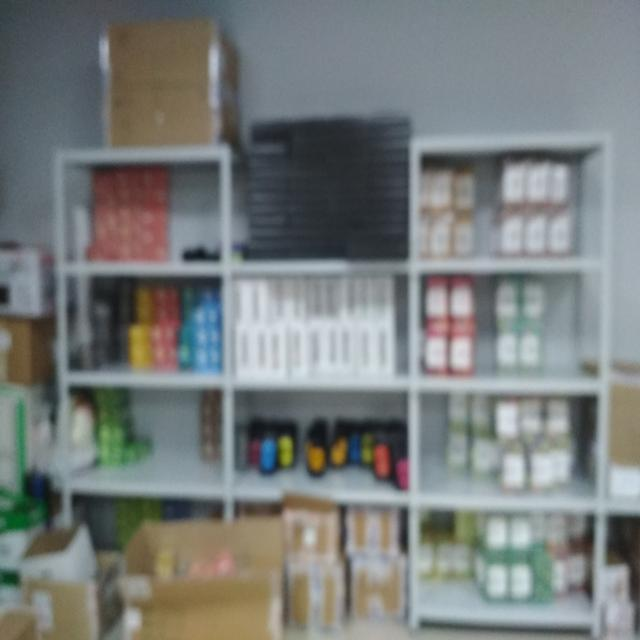

In [1061]:
img_test = Image.open('/Users/yuliabezginova/PycharmProjects/00_files-for_NLP/shift-cv-winter-2023/test/test/azhhybbdtoewbearimuo.jpg')
img_test

### ***Conclusion***: В ходе выполнения проекта были загружены обучающие и тестовые данные с использованием загрузчиков ImageDataGenerator().

Обучающие данные были разделены функцией .flow_from_directory() на обучающую и валидационную подвыборки. Таким образом, обучение модели проводилось на 1998 изображениях и валидировалось на 666 изображениях.

Для построения моделей была предпринята попытка написать три функции data_load(), create_model(), train_model(), то обучить модель с их помощью не удалось.

Затем для нахождения наилучшей модели, были построения три разные сверточные нейронные сети с разными параметрами. Опираясь на показатели метрики, была выбрана одна наилучшая модель.

Наилучшая модель тестировалась на тестовых данных.

Тестовая выборка была использована для предсказаний меток (1 - картинка забурена, 0 - картинка четкая).

После получения предсказаний вероятности, что изображениях четкое, картинки из тестового датасета были переведены в векторный формат и соединены с полученными предсказаниями вероятной со следующей логикой разметки: если вероятность < 0.7, то изображение заблюрено, если нет - изображение четкое.